In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, roc_curve
)

# Detect Colab
IN_COLAB = 'google.colab' in sys.modules
print("Running in Colab" if IN_COLAB else "Running locally")


Running in Colab


In [2]:
from google.colab import files
uploaded = files.upload()  # choose bank-additional-full.csv
filename = list(uploaded.keys())[0]
print('Using file:', filename)

Saving bank.csv to bank (2).csv
Using file: bank (2).csv


In [5]:
import pandas as pd
import csv

# 1) Try pandas engine=python with automatic delimiter detection via csv.Sniffer
with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
    sample = f.read(4096)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=";,")
        delim = dialect.delimiter
    except Exception:
        # Fallback to comma if sniffer fails
        delim = ','

print('Detected delimiter:', repr(delim))

# 2) Read again without header to avoid concatenated header issues
raw = pd.read_csv(filename, header=None, dtype=str, sep=delim, engine='python')
print('Raw shape:', raw.shape)

# 3) If the first row looks like a header (contains alphabetic tokens), treat it as header
first_row = raw.iloc[0].tolist()
looks_like_header = any(any(ch.isalpha() for ch in str(cell)) for cell in first_row)

if looks_like_header:
    # Use the first row as header
    cols = [str(c).strip() for c in first_row]
    df = raw.iloc[1:].reset_index(drop=True).copy()
    # If only one column but header string has commas or semicolons, split that single column
    if df.shape[1] == 1 and ((',' in cols[0]) or (';' in cols[0])):
        # Split header by detected delimiter
        header_split = cols[0].split(delim)
        df = raw.copy()
        # Split the single text column into multiple
        df = df[0].str.split(delim, expand=True)
        # First row is header
        header_split = df.iloc[0].tolist()
        df = df.iloc[1:].reset_index(drop=True)
        df.columns = [h.strip() for h in header_split]
    else:
        df.columns = cols
else:
    # No header row; assign expected columns if matches known schema length, else generic names
    if raw.shape[1] == 17:
        df = raw.copy()
        df.columns = [
            'age','job','marital','education','default','balance','housing','loan',
            'contact','day','month','duration','campaign','pdays','previous','poutcome','deposit'
        ]
    else:
        df = raw.copy()
        df.columns = [f'col_{i}' for i in range(df.shape[1])]

print('After header fix shape:', df.shape)
print('Columns:', list(df.columns))


Detected delimiter: ','
Raw shape: (11163, 17)
After header fix shape: (11162, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']


In [6]:
# If columns appear collapsed again, attempt a final split using detected delimiter
if df.shape[1] == 1 and df.iloc[0, 0].count(delim) >= 16:
    df = df.iloc[:, 0].str.split(delim, expand=True)
    df.columns = [
        'age','job','marital','education','default','balance','housing','loan',
        'contact','day','month','duration','campaign','pdays','previous','poutcome','deposit'
    ]

# Trim whitespace and normalize strings
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).str.strip()

# Coerce numeric types where expected
for c in ['age','balance','day','duration','campaign','pdays','previous']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Normalize target column name/value
TARGET_CANDIDATES = ['deposit','y']
target_col = next((c for c in TARGET_CANDIDATES if c in df.columns), None)
if target_col is None:
    # If header had all fields in one token list, try to detect embedded target
    # As a last resort, check if any column name contains 'deposit'
    target_col = next((c for c in df.columns if 'deposit' in c.lower() or c.lower() == 'y'), None)

if target_col is None:
    raise KeyError(f"Target not found; columns now are: {df.columns.tolist()}")

df[target_col] = df[target_col].str.lower().str.strip()
bank = df.reset_index(drop=True)
print('✅ Finalized DataFrame:', bank.shape, '| target =', target_col)


✅ Finalized DataFrame: (11162, 17) | target = deposit


In [7]:
# Train/Holdout split (stratified)
train, holdout = train_test_split(bank, test_size=0.2, stratify=bank[target_col], random_state=42)

# SEMMA Sample phase: 50% of training for fast iteration
train_sample = train.sample(frac=0.5, random_state=42)

print('\n=== Sampling Strategy ===')
print(f'Full Training Data: {len(train):,} rows')
print(f'Sample Size: {len(train_sample):,} rows ({len(train_sample)/len(train)*100:.1f}%)')
print(f'Holdout (Test) Size: {len(holdout):,} rows')

# Verify class distribution
print('\nClass Distribution in Full Train:', train[target_col].value_counts(normalize=True).to_dict())
print('Class Distribution in Sample:', train_sample[target_col].value_counts(normalize=True).to_dict())

train_sample.head()



=== Sampling Strategy ===
Full Training Data: 8,929 rows
Sample Size: 4,464 rows (50.0%)
Holdout (Test) Size: 2,233 rows

Class Distribution in Full Train: {'no': 0.5261507447642513, 'yes': 0.47384925523574867}
Class Distribution in Sample: {'no': 0.5275537634408602, 'yes': 0.4724462365591398}


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
9908,38,management,married,tertiary,no,1440,no,no,cellular,11,aug,111,2,-1,0,unknown,no
9206,31,admin.,married,secondary,no,8784,yes,no,unknown,21,may,63,2,-1,0,unknown,no
2929,33,technician,married,secondary,no,133,no,no,cellular,12,nov,627,2,192,1,success,yes
662,57,retired,married,secondary,no,466,no,no,cellular,5,aug,641,2,-1,0,unknown,yes
658,36,management,divorced,tertiary,no,0,no,no,cellular,4,aug,1165,1,-1,0,unknown,yes


=== Response Rate Analysis ===
No subscriptions: 2,355 (52.76%)
Yes subscriptions: 2,109 (47.24%)
Imbalance Ratio: 1.1:1


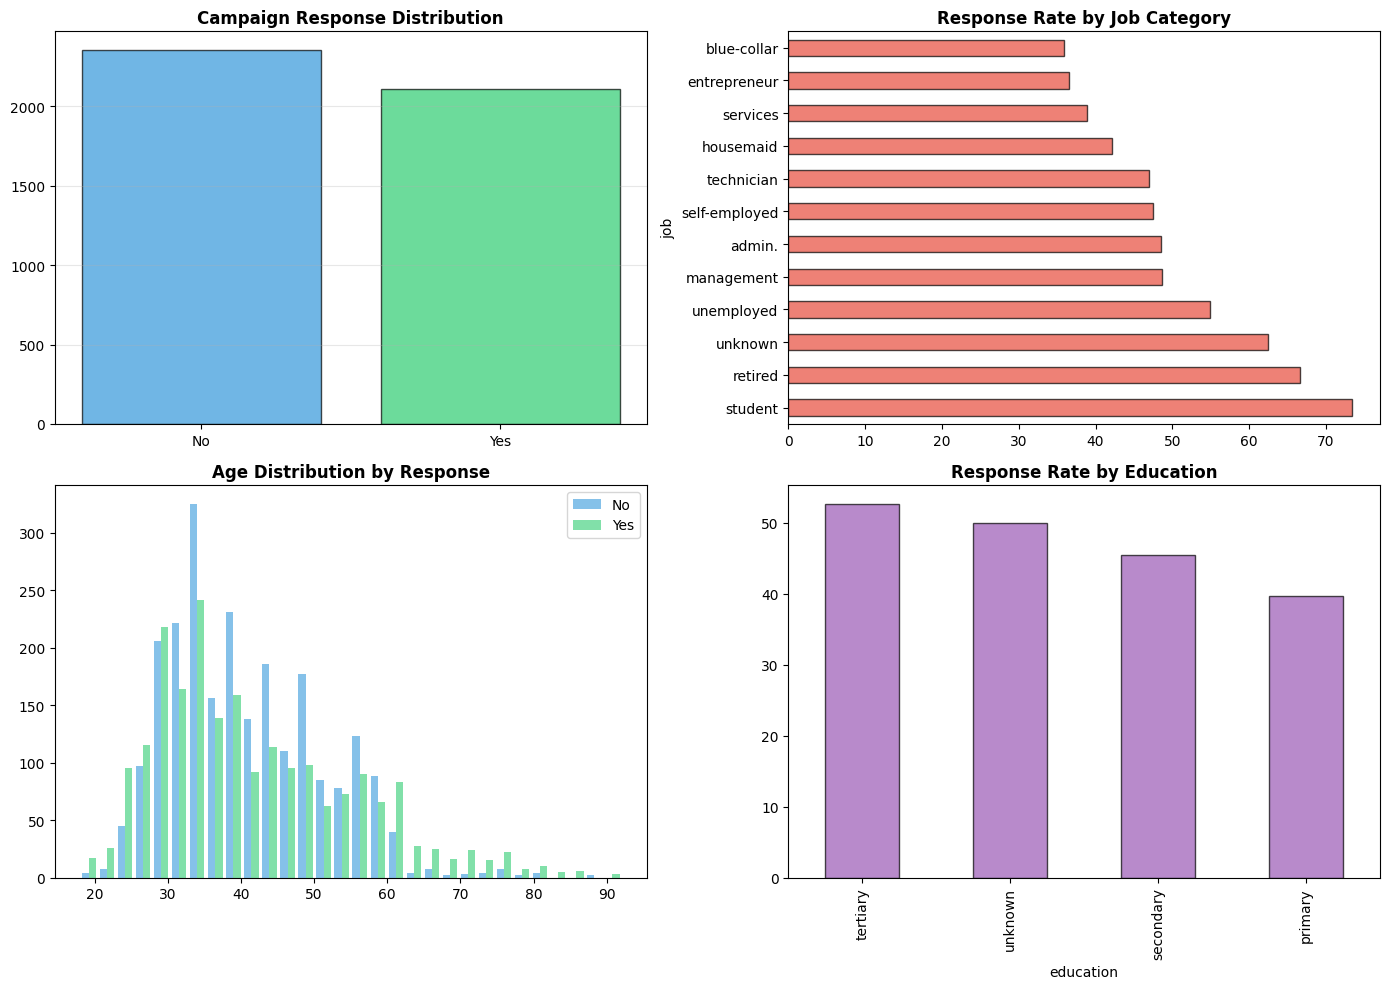

In [8]:
response_counts = train_sample[target_col].value_counts()
response_rate = train_sample[target_col].value_counts(normalize=True)

print('=== Response Rate Analysis ===')
print(f'No subscriptions: {response_counts.get("no",0):,} ({response_rate.get("no",0)*100:.2f}%)')
print(f'Yes subscriptions: {response_counts.get("yes",0):,} ({response_rate.get("yes",0)*100:.2f}%)')
if response_counts.get("yes", 0) > 0:
    print(f'Imbalance Ratio: {response_counts.get("no",0)/response_counts.get("yes",1):.1f}:1')

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Distribution
ax[0, 0].bar(['No', 'Yes'], [response_counts.get('no',0), response_counts.get('yes',0)],
             color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
ax[0, 0].set_title('Campaign Response Distribution', fontsize=12, fontweight='bold')
ax[0, 0].grid(axis='y', alpha=0.3)

# By job (guard missing)
if 'job' in train_sample.columns:
    job_response = train_sample.groupby('job')[target_col].apply(lambda x: (x == 'yes').mean() * 100).sort_values(ascending=False)
    job_response.plot(kind='barh', ax=ax[0, 1], color='#e74c3c', alpha=0.7, edgecolor='black')
    ax[0, 1].set_title('Response Rate by Job Category', fontsize=12, fontweight='bold')
else:
    ax[0, 1].axis('off')

# Age by response
if 'age' in train_sample.columns:
    ax[1, 0].hist([train_sample[train_sample[target_col]=='no']['age'],
                   train_sample[train_sample[target_col]=='yes']['age']],
                  bins=30, label=['No', 'Yes'], color=['#3498db', '#2ecc71'], alpha=0.6)
    ax[1, 0].set_title('Age Distribution by Response', fontsize=12, fontweight='bold')
    ax[1, 0].legend()
else:
    ax[1, 0].axis('off')

# Education
if 'education' in train_sample.columns:
    edu_response = train_sample.groupby('education')[target_col].apply(lambda x: (x == 'yes').mean() * 100).sort_values(ascending=False)
    edu_response.plot(kind='bar', ax=ax[1, 1], color='#9b59b6', alpha=0.7, edgecolor='black')
    ax[1, 1].set_title('Response Rate by Education', fontsize=12, fontweight='bold')
else:
    ax[1, 1].axis('off')

plt.tight_layout()
plt.show()


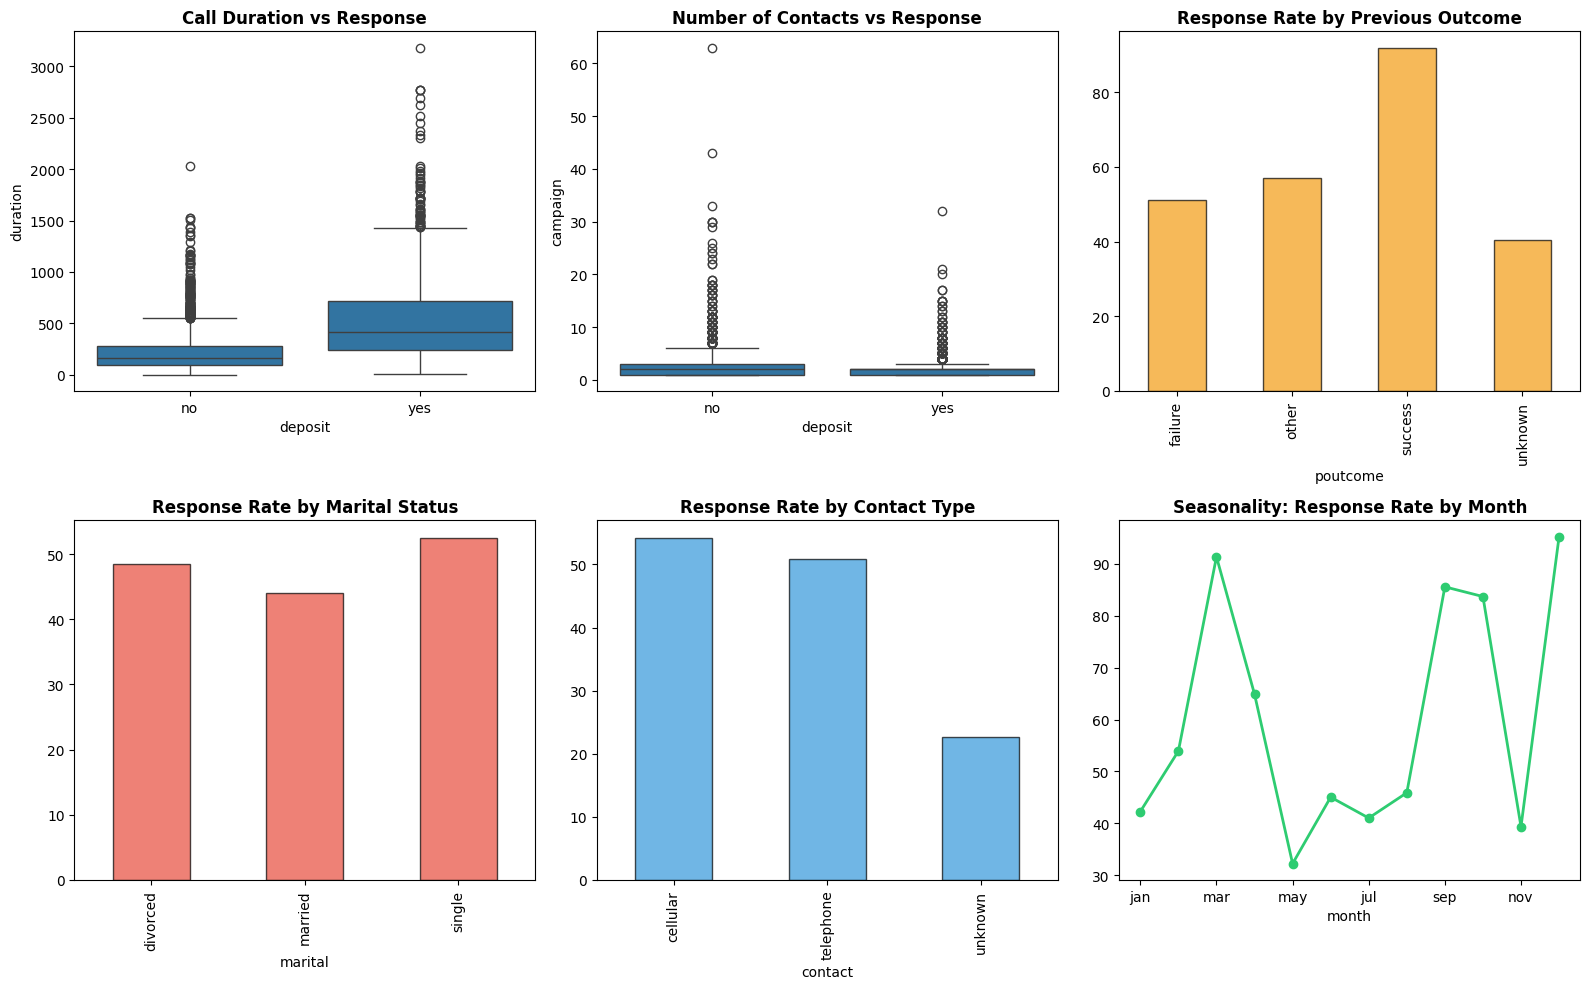

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

# Duration vs Response
if 'duration' in train_sample.columns:
    sns.boxplot(data=train_sample, x=target_col, y='duration', ax=ax[0, 0])
    ax[0, 0].set_title('Call Duration vs Response', fontweight='bold')
else:
    ax[0, 0].axis('off')

# Campaign count vs Response
if 'campaign' in train_sample.columns:
    sns.boxplot(data=train_sample, x=target_col, y='campaign', ax=ax[0, 1])
    ax[0, 1].set_title('Number of Contacts vs Response', fontweight='bold')
else:
    ax[0, 1].axis('off')

# Previous outcome
if 'poutcome' in train_sample.columns:
    prev_outcome_rate = train_sample.groupby('poutcome')[target_col].apply(lambda x: (x == 'yes').mean() * 100)
    prev_outcome_rate.plot(kind='bar', ax=ax[0, 2], color='#f39c12', alpha=0.7, edgecolor='black')
    ax[0, 2].set_title('Response Rate by Previous Outcome', fontweight='bold')
else:
    ax[0, 2].axis('off')

# Marital
if 'marital' in train_sample.columns:
    marital_response = train_sample.groupby('marital')[target_col].apply(lambda x: (x == 'yes').mean() * 100)
    marital_response.plot(kind='bar', ax=ax[1, 0], color='#e74c3c', alpha=0.7, edgecolor='black')
    ax[1, 0].set_title('Response Rate by Marital Status', fontweight='bold')
else:
    ax[1, 0].axis('off')

# Contact type
if 'contact' in train_sample.columns:
    contact_response = train_sample.groupby('contact')[target_col].apply(lambda x: (x == 'yes').mean() * 100)
    contact_response.plot(kind='bar', ax=ax[1, 1], color='#3498db', alpha=0.7, edgecolor='black')
    ax[1, 1].set_title('Response Rate by Contact Type', fontweight='bold')
else:
    ax[1, 1].axis('off')

# Month seasonality
if 'month' in train_sample.columns:
    month_response = train_sample.groupby('month')[target_col].apply(lambda x: (x == 'yes').mean() * 100)
    month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    month_response = month_response.reindex([m for m in month_order if m in month_response.index])
    month_response.plot(kind='line', ax=ax[1, 2], marker='o', color='#2ecc71', linewidth=2)
    ax[1, 2].set_title('Seasonality: Response Rate by Month', fontweight='bold')
else:
    ax[1, 2].axis('off')

plt.tight_layout(); plt.show()


In [10]:
print('=== SEMMA Modify Phase: Feature Engineering ===\n')

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if 'age' in df.columns:
        df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65, 100],
                                 labels=['young', 'adult', 'middle', 'senior', 'elderly'])
    if set(['campaign', 'previous']).issubset(df.columns):
        df['contact_intensity'] = df['campaign'] + df['previous']
    if set(['emp.var.rate', 'cons.price.idx']).issubset(df.columns):
        df['economic_score'] = df['emp.var.rate'] + df['cons.price.idx'] / 100
    if 'previous' in df.columns:
        df['has_previous'] = (df['previous'] > 0).astype(int)
    if 'poutcome' in df.columns:
        df['prev_success'] = (df['poutcome'] == 'success').astype(int)
    return df

train_sample_eng = engineer_features(train_sample)

X = train_sample_eng.drop(columns=[target_col])
y = train_sample_eng[target_col].map({'no': 0, 'yes': 1})

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

semma_preprocess = ColumnTransformer(transformers=[
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols),
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ]), numeric_cols)
], remainder='drop')

print('✓ Preprocessing pipeline ready')


=== SEMMA Modify Phase: Feature Engineering ===

✓ Preprocessing pipeline ready


In [11]:
print('=== SEMMA Model Phase: Comparative Modeling ===\n')

# Prepare holdout with engineered features
holdout_eng = engineer_features(holdout)
X_test = holdout_eng.drop(columns=[target_col])
y_test = holdout_eng[target_col].map({'no': 0, 'yes': 1})

models = {}
results = []

# 1. Logistic Regression
print('Training Logistic Regression...')
lr_model = Pipeline([('prep', semma_preprocess),
                     ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
lr_model.fit(X, y)
lr_probs = lr_model.predict_proba(X_test)[:, 1]
lr_preds = (lr_probs >= 0.3).astype(int)
models['Logistic Regression'] = lr_model
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': (lr_preds == y_test).mean(),
    'Precision': precision_score(y_test, lr_preds),
    'Recall': recall_score(y_test, lr_preds),
    'F1-Score': f1_score(y_test, lr_preds),
    'ROC-AUC': roc_auc_score(y_test, lr_probs)
})
print(f'✓ Logistic Regression ROC-AUC: {results[-1]["ROC-AUC"]:.4f}')

# 2. Decision Tree
print('Training Decision Tree...')
dt_model = Pipeline([('prep', semma_preprocess),
                     ('clf', DecisionTreeClassifier(max_depth=10, min_samples_split=50, class_weight='balanced', random_state=42))])
dt_model.fit(X, y)
dt_probs = dt_model.predict_proba(X_test)[:, 1]
dt_preds = (dt_probs >= 0.3).astype(int)
models['Decision Tree'] = dt_model
results.append({
    'Model': 'Decision Tree',
    'Accuracy': (dt_preds == y_test).mean(),
    'Precision': precision_score(y_test, dt_preds),
    'Recall': recall_score(y_test, dt_preds),
    'F1-Score': f1_score(y_test, dt_preds),
    'ROC-AUC': roc_auc_score(y_test, dt_probs)
})
print(f'✓ Decision Tree ROC-AUC: {results[-1]["ROC-AUC"]:.4f}')

# 3. Random Forest
print('Training Random Forest...')
rf_model = Pipeline([('prep', semma_preprocess),
                     ('clf', RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1))])
rf_model.fit(X, y)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_preds = (rf_probs >= 0.3).astype(int)
models['Random Forest'] = rf_model
results.append({
    'Model': 'Random Forest',
    'Accuracy': (rf_preds == y_test).mean(),
    'Precision': precision_score(y_test, rf_preds),
    'Recall': recall_score(y_test, rf_preds),
    'F1-Score': f1_score(y_test, rf_preds),
    'ROC-AUC': roc_auc_score(y_test, rf_probs)
})
print(f'✓ Random Forest ROC-AUC: {results[-1]["ROC-AUC"]:.4f}')

# 4. Gradient Boosting
print('Training Gradient Boosting...')
gb_model = Pipeline([('prep', semma_preprocess),
                     ('clf', GradientBoostingClassifier(n_estimators=150, max_depth=3, learning_rate=0.1, random_state=42))])
gb_model.fit(X, y)
gb_probs = gb_model.predict_proba(X_test)[:, 1]
gb_preds = (gb_probs >= 0.3).astype(int)
models['Gradient Boosting'] = gb_model
results.append({
    'Model': 'Gradient Boosting',
    'Accuracy': (gb_preds == y_test).mean(),
    'Precision': precision_score(y_test, gb_preds),
    'Recall': recall_score(y_test, gb_preds),
    'F1-Score': f1_score(y_test, gb_preds),
    'ROC-AUC': roc_auc_score(y_test, gb_probs)
})
print(f'✓ Gradient Boosting ROC-AUC: {results[-1]["ROC-AUC"]:.4f}')

# 5. XGBoost (optional)
try:
    from xgboost import XGBClassifier
    scale_pos = (y == 0).sum() / max((y == 1).sum(), 1)
    xgb_model = Pipeline([('prep', semma_preprocess),
                          ('clf', XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                                                scale_pos_weight=scale_pos, random_state=42, eval_metric='logloss'))])
    xgb_model.fit(X, y)
    xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
    xgb_preds = (xgb_probs >= 0.3).astype(int)
    models['XGBoost'] = xgb_model
    results.append({
        'Model': 'XGBoost',
        'Accuracy': (xgb_preds == y_test).mean(),
        'Precision': precision_score(y_test, xgb_preds),
        'Recall': recall_score(y_test, xgb_preds),
        'F1-Score': f1_score(y_test, xgb_preds),
        'ROC-AUC': roc_auc_score(y_test, xgb_probs)
    })
    print(f'✓ XGBoost ROC-AUC: {results[-1]["ROC-AUC"]:.4f}')
except Exception as e:
    print('XGBoost unavailable. Skipping.', e)

comparison_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)
print('\n=== Model Comparison Summary ===')
print(comparison_df.to_string(index=False))


=== SEMMA Model Phase: Comparative Modeling ===

Training Logistic Regression...
✓ Logistic Regression ROC-AUC: 0.9063
Training Decision Tree...
✓ Decision Tree ROC-AUC: 0.8859
Training Random Forest...
✓ Random Forest ROC-AUC: 0.9154
Training Gradient Boosting...
✓ Gradient Boosting ROC-AUC: 0.9216
✓ XGBoost ROC-AUC: 0.9245

=== Model Comparison Summary ===
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            XGBoost  0.855799   0.789764 0.948015  0.861684 0.924483
  Gradient Boosting  0.849082   0.778378 0.952741  0.856779 0.921560
      Random Forest  0.825795   0.741168 0.971645  0.840900 0.915430
Logistic Regression  0.815047   0.745621 0.925331  0.825812 0.906264
      Decision Tree  0.815495   0.753135 0.908318  0.823479 0.885895


🏆 Champion Model: XGBoost

=== XGBoost Classification Report ===
                 precision    recall  f1-score   support

No Subscription       0.94      0.77      0.85      1175
   Subscription       0.79      0.95      0.86      1058

       accuracy                           0.86      2233
      macro avg       0.87      0.86      0.86      2233
   weighted avg       0.87      0.86      0.86      2233



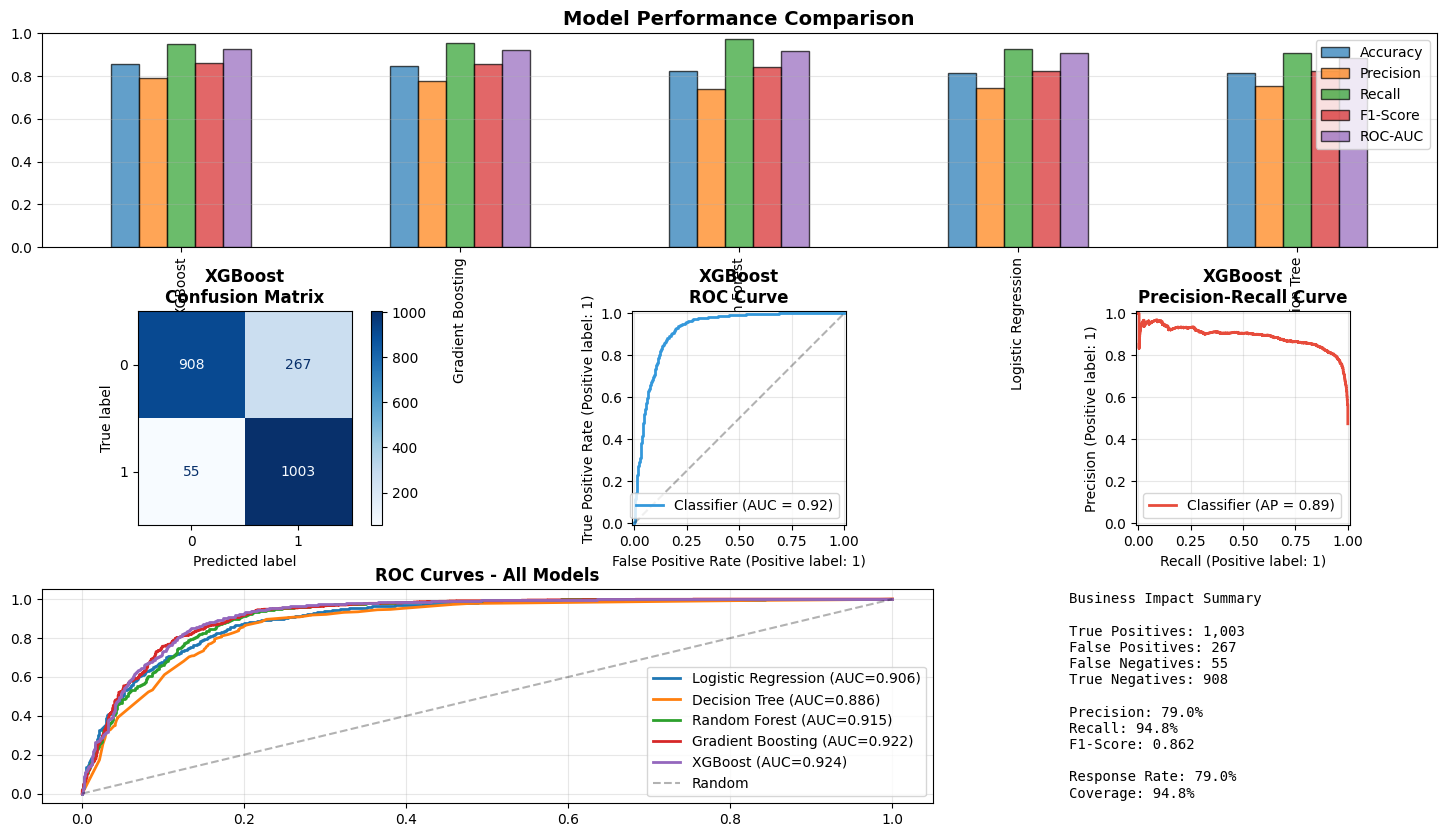


✓ Assessment complete


In [12]:
champion_name = comparison_df.iloc[0]['Model']
champion_model = models[champion_name]
print(f'🏆 Champion Model: {champion_name}')
champion_probs = champion_model.predict_proba(X_test)[:, 1]
champion_preds = (champion_probs >= 0.3).astype(int)

print(f'\n=== {champion_name} Classification Report ===')
print(classification_report(y_test, champion_preds, target_names=['No Subscription', 'Subscription']))

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
comparison_df.set_index('Model')[['Accuracy','Precision','Recall','F1-Score','ROC-AUC']].plot(kind='bar', ax=ax1, alpha=0.7, edgecolor='black')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold'); ax1.set_ylim(0,1); ax1.grid(axis='y', alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])
ConfusionMatrixDisplay.from_predictions(y_test, champion_preds, ax=ax2, cmap='Blues')
ax2.set_title(f'{champion_name}\nConfusion Matrix', fontweight='bold')

ax3 = fig.add_subplot(gs[1, 1])
RocCurveDisplay.from_predictions(y_test, champion_probs, ax=ax3, color='#3498db', linewidth=2)
ax3.plot([0,1],[0,1],'k--', alpha=0.3); ax3.set_title(f'{champion_name}\nROC Curve', fontweight='bold'); ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(gs[1, 2])
PrecisionRecallDisplay.from_predictions(y_test, champion_probs, ax=ax4, color='#e74c3c', linewidth=2)
ax4.set_title(f'{champion_name}\nPrecision-Recall Curve', fontweight='bold'); ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[2, :2])
for mname, mobj in models.items():
    probs = mobj.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    ax5.plot(fpr, tpr, label=f'{mname} (AUC={roc_auc_score(y_test, probs):.3f})', linewidth=2)
ax5.plot([0,1],[0,1], 'k--', alpha=0.3, label='Random')
ax5.set_title('ROC Curves - All Models', fontsize=12, fontweight='bold'); ax5.legend(loc='lower right'); ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[2, 2]); ax6.axis('off')
cm = confusion_matrix(y_test, champion_preds); tn, fp, fn, tp = cm.ravel()
metrics_text = f"""
Business Impact Summary

True Positives: {tp:,}
False Positives: {fp:,}
False Negatives: {fn:,}
True Negatives: {tn:,}

Precision: {precision_score(y_test, champion_preds):.1%}
Recall: {recall_score(y_test, champion_preds):.1%}
F1-Score: {f1_score(y_test, champion_preds):.3f}

Response Rate: {tp/(tp+fp+1e-12)*100:.1f}%
Coverage: {tp/(tp+fn+1e-12)*100:.1f}%
"""
ax6.text(0.05, 0.5, metrics_text, fontsize=10, family='monospace', va='center')
plt.show()

print('\n✓ Assessment complete')


In [13]:
from joblib import dump
import json
from datetime import datetime

artifacts = Path('../app/artifacts')
artifacts.mkdir(exist_ok=True, parents=True)

dump(champion_model, artifacts / 'bank_marketing_semma.joblib')
dump(engineer_features, artifacts / 'feature_engineering_fn.joblib')
print(f'✓ Saved: {artifacts / "bank_marketing_semma.joblib"}')
print('✓ Saved feature engineering function')

model_card = {
    'model_name': 'Bank Marketing Campaign Response Predictor',
    'version': '1.0.0',
    'created_date': datetime.now().isoformat(),
    'methodology': 'SEMMA',
    'algorithm': champion_name,
    'training_data': {
        'source': 'Kaggle - Bank Marketing Dataset',
        'full_dataset_size': int(len(bank)),
        'sample_size': int(len(train_sample)),
        'test_size': int(len(holdout)),
        'target_column': target_col
    },
    'performance_metrics': {
        'test_accuracy': float(comparison_df[comparison_df['Model']==champion_name]['Accuracy'].values[0]),
        'test_precision': float(comparison_df[comparison_df['Model']==champion_name]['Precision'].values[0]),
        'test_recall': float(comparison_df[comparison_df['Model']==champion_name]['Recall'].values[0]),
        'test_f1': float(comparison_df[comparison_df['Model']==champion_name]['F1-Score'].values[0]),
        'test_roc_auc': float(comparison_df[comparison_df['Model']==champion_name]['ROC-AUC'].values[0])
    },
    'deployment_notes': {
        'preprocessing': 'Apply engineer_features, then use saved pipeline',
        'threshold': 0.3,
        'inference_mode': 'Batch scoring for campaign targeting'
    }
}
with open(artifacts / 'model_card.json', 'w') as f:
    json.dump(model_card, f, indent=2)
print(f'✓ Model card saved to {artifacts / "model_card.json"}')


✓ Saved: ../app/artifacts/bank_marketing_semma.joblib
✓ Saved feature engineering function
✓ Model card saved to ../app/artifacts/model_card.json
